# Super Store Segmentation and Discount Analysis 

## Backgroud

- Super Store adalah supermarket yang sangat besar, seringkali menjual barang-barang rumah tangga, pakaian, dan barang-barang elektronik, serta makanan. Superstore biasanya mengenakan biaya mulai dari 15 hingga 45 persen lebih murah daripada rekan mereka yang lebih kecil
- Super Store memiliki keuntungan yang tinggi, namun keuntungannya tidak maksimal 
- Super Store mengadakan promo diskon untuk semua pelanggan mulai dari 10% - 80%

## Objective 

- Membuat segmentasi pelanggan Super Store untuk memahami profil pelanggan
- Melakukan analisis diskon berdasarkan segmentasi pelanggan
- Membuat rekomendasi diskon yang sesuai
- Identifikasi masalah atau kelemahan bisnis untuk meningkatkan keuntungan

### Note : hasil analisis pada jupyther notebook bisa berbeda dengan yang terdapat pada deck atau ppt 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

from scipy.spatial import ConvexHull

from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

# load lifetimes plotting module
from lifetimes.plotting import *
# load lifetimes utils module
from lifetimes.utils import *
# load BetaGeoFitter model
from lifetimes import BetaGeoFitter
# load GammaGammaFitter
from lifetimes import GammaGammaFitter

## Import Dataset 

In [2]:
df2 = pd.read_csv('Superstore.csv', encoding='latin1')

In [3]:
df2.head()

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]

In [4]:
df2["Order Date"] = pd.to_datetime(df2['Order Date'], infer_datetime_format=True)

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   object        
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

Features

1. Row ID => Unique ID for each row.
2. Order ID => Unique Order ID for each Customer.
3. Order Date => Order Date of the product.
4. Ship Date => Shipping Date of the Product.
5. Ship Mode=> Shipping Mode specified by the Customer.
6. Customer ID => Unique ID to identify each Customer.
7. Customer Name => Name of the Customer.
8. Segment => The segment where the Customer belongs.
9. Country => Country of residence of the Customer.
10. City => City of residence of of the Customer.
11. State => State of residence of the Customer.
12. Postal Code => Postal Code of every Customer.
13. Region => Region where the Customer belong.
14. Product ID => Unique ID of the Product.
15. Category => Category of the product ordered.
16. Sub-Category => Sub-Category of the product ordered.
17. Product Name => Name of the Product
18. Sales => Sales of the Product.
19. Quantity => Quantity of the Product.
20. Discount => Discount provided.
21. Profit => Profit/Loss incurred.

## Data Cleaning

In [6]:
df2.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

## Feature Enginering

In [7]:
df2.columns = df2.columns.str.replace(" ", "_").str.lower()
df2.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub-category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [8]:
df2.rename(columns={'sales': 'GMV'}, inplace=True)

In [9]:
df2.drop(['row_id'], axis='columns', inplace=True)

In [10]:
df2["order_date"] = pd.to_datetime(df2['order_date'])

In [11]:
df2['discount'] = df2['discount'] * 100

### Find the unit price

In [12]:
df2['unit_price'] = (100/(100 - df2['discount']) * df2['GMV']) / df2['quantity']

In [13]:
cols = df2.columns.tolist()
column_to_move = "customer_id"
new_position = 0

cols.insert(new_position, cols.pop(cols.index(column_to_move)))
df2 = df2[cols]

In [14]:
cols = df2.columns.tolist()
column_to_move = "unit_price"
new_position = 16

cols.insert(new_position, cols.pop(cols.index(column_to_move)))
df2 = df2[cols]

In [15]:
cols = df2.columns.tolist()
column_to_move = "quantity"
new_position = 17

cols.insert(new_position, cols.pop(cols.index(column_to_move)))
df2 = df2[cols]

In [16]:
cols = df2.columns.tolist()
column_to_move = "discount"
new_position = 18

cols.insert(new_position, cols.pop(cols.index(column_to_move)))
df2 = df2[cols]

In [17]:
df2.head()

customer_id        order_id order_date   ship_date       ship_mode  \
0    CG-12520  CA-2016-152156 2016-11-08  11/11/2016    Second Class   
1    CG-12520  CA-2016-152156 2016-11-08  11/11/2016    Second Class   
2    DV-13045  CA-2016-138688 2016-06-12   6/16/2016    Second Class   
3    SO-20335  US-2015-108966 2015-10-11  10/18/2015  Standard Class   
4    SO-20335  US-2015-108966 2015-10-11  10/18/2015  Standard Class   

     customer_name    segment        country             city       state  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   ...  region       product_id         category sub-category  \
0  ...   South  FUR-BO-10001798        Furniture    Bookcases   
1  ...   South  FUR-CH-10000454        Furniture       Chairs   
2  ...    West  OFF-LA-10000240  Office Supplies       Labels   
3  ...   South  FUR-TA-10000577        Furniture       Tables   
4  ...   South  OFF-ST-10000760  Office Supplies      Storage   

                                        product_name unit_price  quantity  \
0                  Bush Somerset Collection Bookcase     130.98         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...     243.98         3   
2  Self-Adhesive Address Labels for Typewriters b...       7.31         2   
3      Bretford CR4500 Series Slim Rectangular Table     348.21         5   
4                     Eldon Fold 'N Roll Cart System      13.98         2   

   discount       GMV    profit  
0       0.0  261.9600   41.9136  
1       0.0  731.9400  219.5820  
2       0.0   14.6200    6.8714  
3      45.0  957.5775 -383.0310  
4      20.0   22.3680    2.5164  

[5 rows x 21 columns]

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    9994 non-null   object        
 1   order_id       9994 non-null   object        
 2   order_date     9994 non-null   datetime64[ns]
 3   ship_date      9994 non-null   object        
 4   ship_mode      9994 non-null   object        
 5   customer_name  9994 non-null   object        
 6   segment        9994 non-null   object        
 7   country        9994 non-null   object        
 8   city           9994 non-null   object        
 9   state          9994 non-null   object        
 10  postal_code    9994 non-null   int64         
 11  region         9994 non-null   object        
 12  product_id     9994 non-null   object        
 13  category       9994 non-null   object        
 14  sub-category   9994 non-null   object        
 15  product_name   9994 n

# EDA

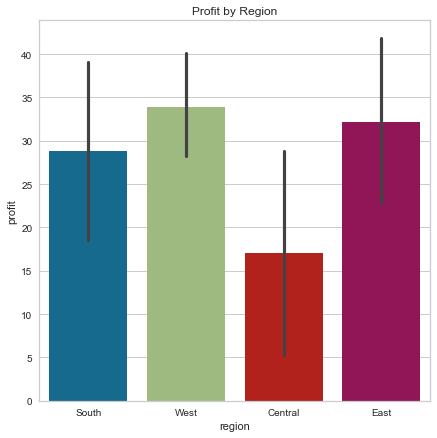

In [19]:
fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.barplot(data = df2, x='region', y='profit')
plt.title("Profit by Region")
plt.show()

Findings : 
1. Region East memiliki profit yang tinggi
2. Region Central memiliki profit yang rendah

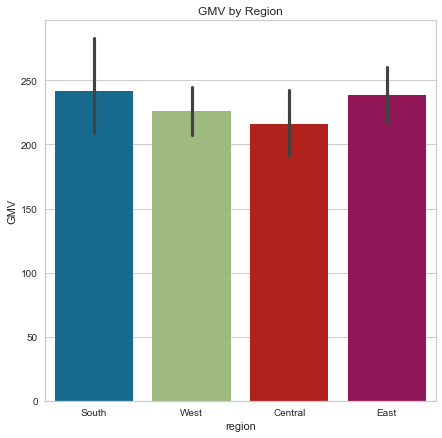

In [20]:
fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.barplot(data = df2, x='region', y='GMV')
plt.title("GMV by Region")
plt.show()

Findings : 
1. Region East memiliki GMV yang tinggi 
2. Region Central memiliki GMV paling rendah 
3. Perbedaan GMV pada setiap Region tidak bergitu tinggi
4. Nampaknya, Region Central memberikan banyak promosi, sehingga profit yang dihasilkan kurang maksomal
5. Nampaknya, Region South, West, dan East memiliki banyak pelanggan yang loyal, sehingga region tersebut dapat mengatur promo dengan baik

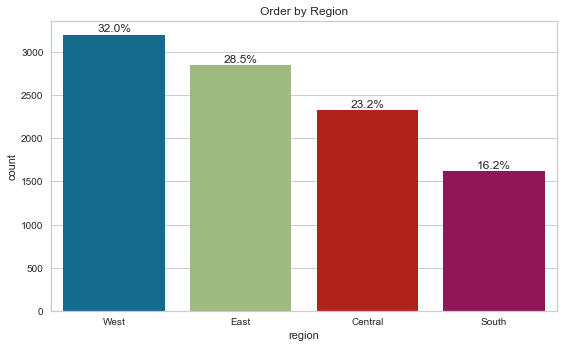

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x='region', order = df2['region'].value_counts().index, data = df2)
plt.title("Order by Region")
total1 = len(df2)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

1. Tingkat pesanan region south yang paling rendah, namun bisa menghasilkan Profit yang bersaing dengan region East dan West
2. Sedangkan pada region central, memiliki lebih banyak order tetapi, profitnya masih rendah
3. Nampaknya, promosi yang dilakukan memang berdampak pada regional central terhadap profit atau memang regional south menjual produk unggulan yang memiliki profit yang tinggi

In [22]:
df2.groupby('region').agg(Total_Customer=('customer_id', 'nunique'))

Total_Customer
region                 
Central             629
East                674
South               512
West                686

Findings : 
1. Perbedaan total pelanggan disetiap region tidak bergitu tinggi 
2. Nampaknya, Region Central melakukan banyak promo untuk meningkatkan jumlah pelanggan 
3. Sepertinya, Region South memiliki banyak pelanggan setia dan loyal, region tersebut memiiki pelanggan yang paling sedikit, namun memiliki profit yang tinggi

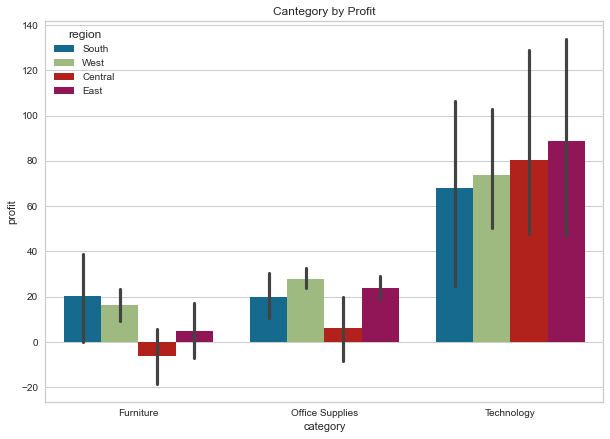

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.barplot(data = df2, x='category', y='profit', hue = 'region')
plt.title("Cantegory by Profit")
plt.show()

Findings : 
1. Kategori Teknologi memiliki keuntungan paling tinggi dibandingkan kategori lainnya, karena harga kategori Teknologi sangat tinggi dan setiap pelanggan membutuhkan produk kategori Teknologi
2. Sepertinya, region east dan central melakukan promo pada kategori Furniture atau memang, pesanan pada regional east untuk kategori furnitur memang rendah
3. Central Region sepertinya melakukan promo dengan produk kategori Office Supplies

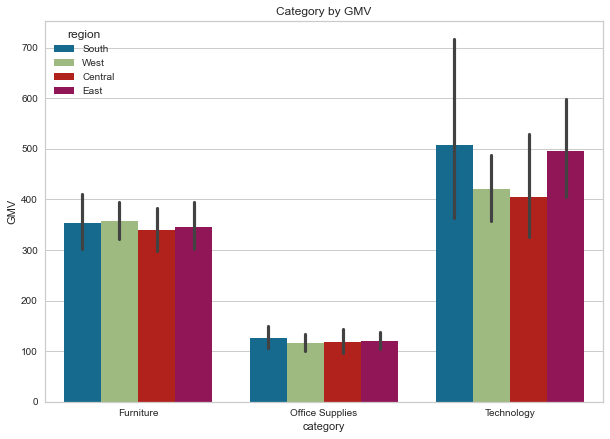

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.barplot(data = df2, x='category', y='GMV', hue = 'region')
plt.title("Category by GMV")
plt.show()

Findings : 
1. Secara keseluruhan, GMV pada region di setiap kategori produk sudah cukup bagus
2. Total GMV tidak terdapat perbedaan yang signifikan pada tiap region
3. Terdapat perbedaan yang signifikat pada GMV kaetgori produk Office Supplies dan Furniture
4. Office Supplies dan Furniture adalah kategori produk yang memiliki GMV tinggi pada region central, namun sangat rendah pada profit
5. Nampaknya, regional central menggunakan kategory furniture dan Office supplies untuk meningkatkan pengguna baru atau memberikan treament ke pengguna lama

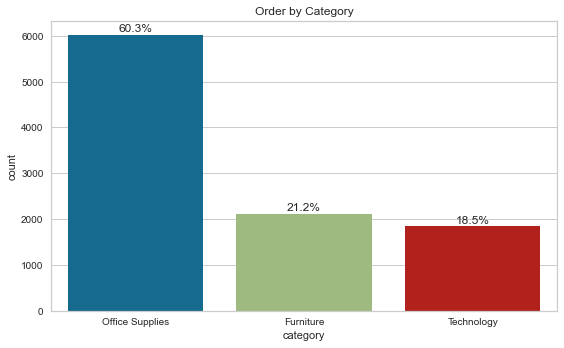

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x='category', order = df2['category'].value_counts().index, data = df2)
plt.title("Order by Category")
total1 = len(df2)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings : 
1. Kategori Produk Office Supplies memiliki order tertinggi
2. Kategori Produk Office Supplies memiliki GMV paling rendah dibandingkan Kategori Produk lainnya
3. Sepertinya Kategori Produk Office Supplies memiliki harga yang murah dan memiliki banyak promo
4. Kategori Produk Perlengkapan Kantor merupakan Kategori Produk yang terbaik untuk Promosi, karena memiliki banyak sekali pesanan
5. Sepertinya permintaan Perlengkapan Kantor sangat tinggi di Super Store

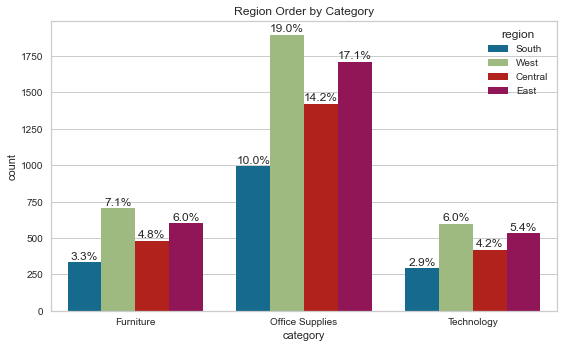

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x='category', hue = 'region', data = df2)
plt.title("Region Order by Category")
total1 = len(df2)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :

1. Berdasarkan countplot, Office Supplies memiliki urutan tertinggi dibanding kategori produk lainnya
2. Seperti yang kami sampaikan sebelumnya, sepertinya  Office Supplies memiliki permintaan yang begitu tinggi, murah, dan memberikan promo. Jadi Office Supplies memiliki urutan tertinggi
3. Namun, profit tertinggi adalah milik kategori produk Teknologi
4. Super Store perlu meningkatkan kategori produk Teknologi untuk meningkatkan Profit dengan promo
5. Kebutuhan Office banyak sekali ordernya di setiap daerah, maka Super Store perlu menurunkan promonya, saya rasa mereka membeli produk tersebut karena mereka membutuhkannya
5. Super Store berusaha meningkatkan pesanan Kategori Produk Furnitur dengan promo dan menurut saya baik dan benar
6. Menurut saya Kategori Produk Furnitur adalah Produk Kategori nomor 3 atau bukan Product Caregories utama oleh Super Store, namun memiliki GMV yang sangat tinggi, sehingga Super Store mencoba untuk memperkenalkan Kategori Produk Furnitur melalui promo

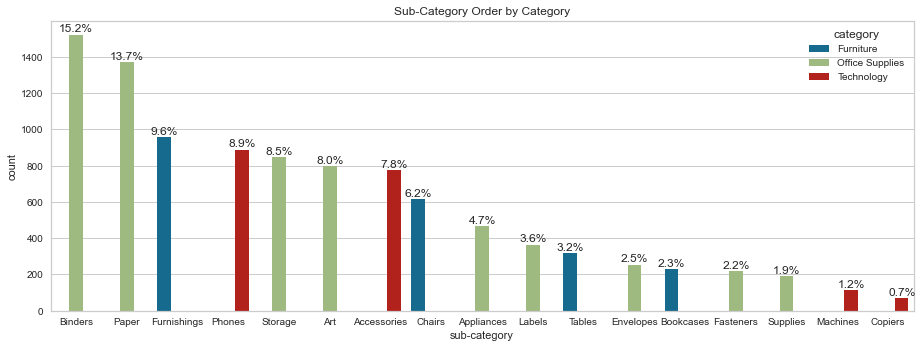

In [27]:
fig, ax = plt.subplots(figsize=(13, 5))
ax = sns.countplot(x='sub-category',hue='category', order = df2['sub-category'].value_counts().index, data = df2)
plt.title("Sub-Category Order by Category")
total1 = len(df2)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
1. Berdasarkan pesanan Produk Sub Kategori, seperti yang saya katakan sebelumnya, Super Store perlu mengurangi promo untuk Kategori Produk Perlengkapan Kantor karena, sepertinya promo meningkatkan GMV dan Order tetapi, keuntungannya sangat rendah
2. Super Store sangat perlu meningkatkan pesanan pada Kategori Produk Furnitur dan Teknologi
3. Namun kami dapat melihat kemajuan promosi pada Kategori Produk Furnitur dan Teknologi Sub-Produk (Telepon dan Perabotan) berada di urutan 5 teratas

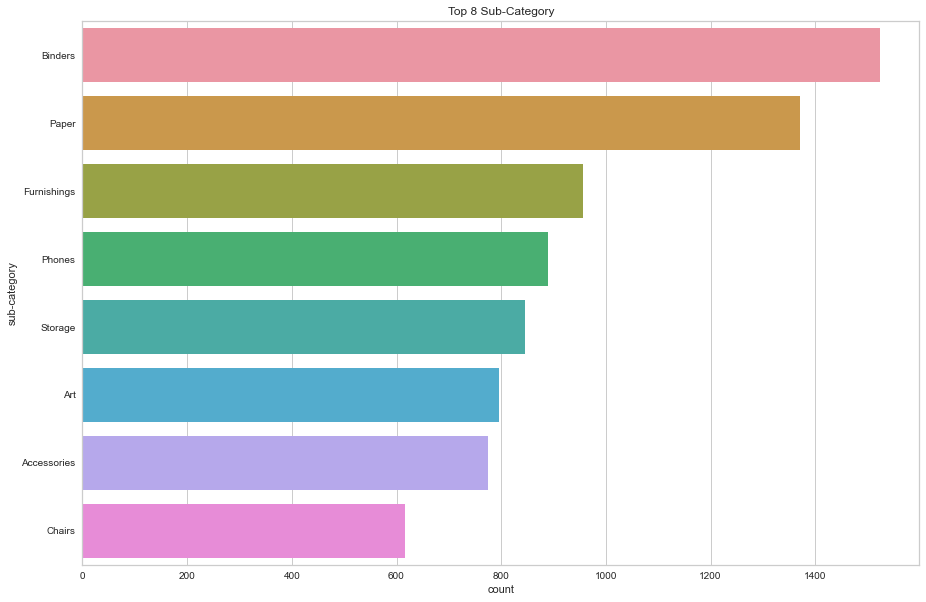

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.title("Top 8 Sub-Category")
sns.countplot(data=df2, y="sub-category", order = df2['sub-category'].value_counts().head(8).index)
plt.show()

Findings :
1. 8 produk teratas berdasarkan Sub-Kategori di Super Store
2. Binder berasal dari Kategori Produk Office Supplies dan urutan tertinggi dari Sub-Category
3. Super Store perlu meningkatkan order dari Sub-Kategori berdasarkan Kategori Produk Furiture dan Teknologi untuk meningkatkan Profit

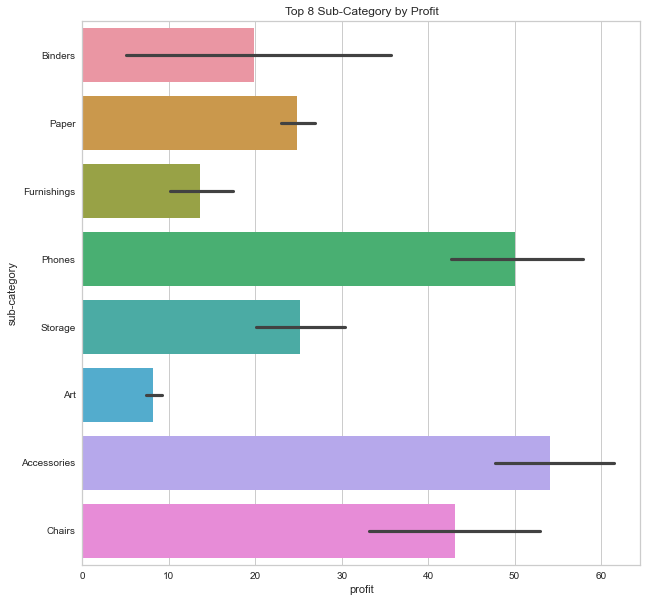

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Top 8 Sub-Category by Profit")
ax = sns.barplot(data = df2, x='profit', y='sub-category', order = df2['sub-category'].value_counts().head(8).index)
plt.show()

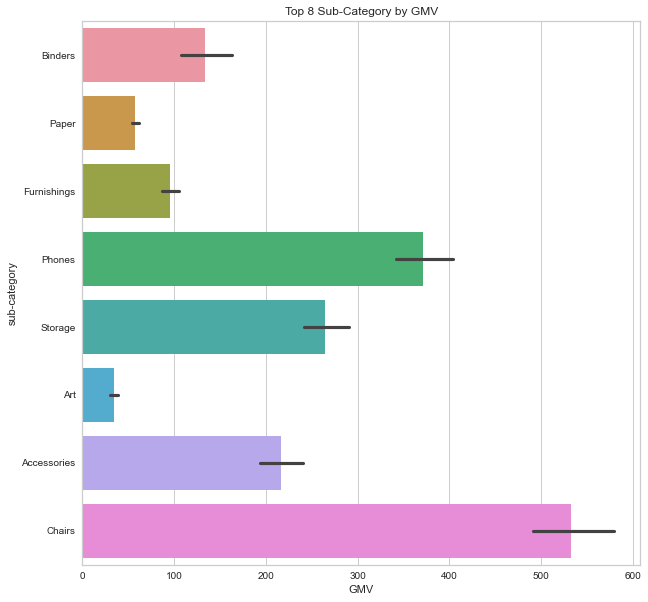

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Top 8 Sub-Category by GMV")
ax = sns.barplot(data = df2, x='GMV', y='sub-category', order = df2['sub-category'].value_counts().head(8).index)
plt.show()

Findings : 
1. Jika kita bandingkan GMV dan Profit dengan 8 produk teratas hasilnya sangat bagus, karena GMV dan Profit sedikit berbeda di antara setiap produk
2. 8 produk teratas memiliki kinerja yang baik, sehingga Super Store perlu meningkatkan 9 Terbawah untuk meningkatkan keuntungan.
3. Super Store perlu menurunkan promo pada 8 produk teratas

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.title("Bottom 9 Sub-Category")
sns.countplot(data=df2, y="sub-category", order = df2['sub-category'].value_counts().tail(9).index)
plt.show()

Findings :
1. 9 Sub-Kategori Terbawah di Super Store
2. Super Store perlu meningkatkan order Sub-Kategori berdasarkan Kategori Produk Furiture dan Teknologi untuk meningkatkan profit
3. Berdasarkan plot 9 Sub-Kategori Terbawah, Super Store perlu ditingkatkan dengan promosi pada Sub-Kategori 9 Terbawah
4. Tim pemasaran dapat membuat program promosi atau program iklan untuk Sub-Kategori 9 Terbawah exp : membuat etalase promo pada Sub-Kategori 9 Terbawah dan meletakkannya di depan
5. Buat iklan online atau berkolaborasi dengan Influencer untuk memperkenalkan 9 Produk Sub-Kategori terbawah

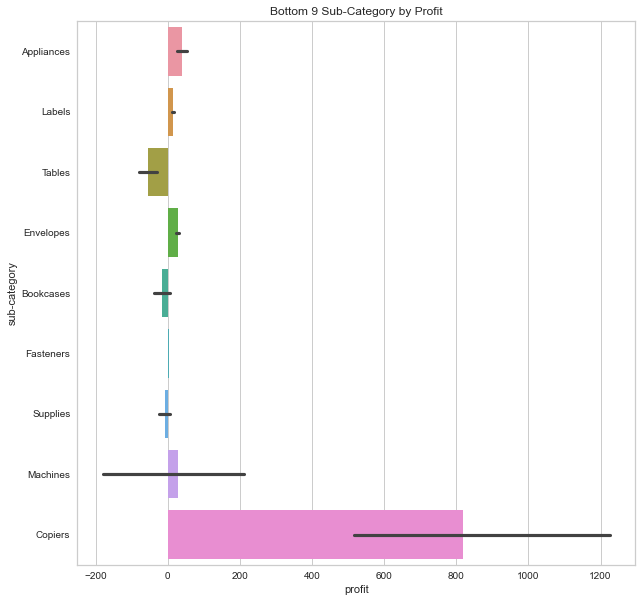

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Bottom 9 Sub-Category by Profit")
ax = sns.barplot(data = df2, x='profit', y='sub-category', order = df2['sub-category'].value_counts().tail(9).index)
plt.show()

Findings :
1. Sub-Kategori 9 Terbawah bedasarkan Profit, Super Store melakukan promo yang tepat tetapi mereka perlu memaksimalkan promosi Sub-Kategori 9 Terbawah
2. Kami tidak dapat melihat biaya operasionalnya, tetapi saya berasumsi, rendahnya profit Sub-Kategori 9 Terbawah itu karena promosi
3. Super Store perlu membuat produk promosi yang baik untuk memperkenalkan produk
4. Super Store dapat menggunakan Iklan Digital untuk memperkenalkan produk Sub-Kategori 9 Terbawah

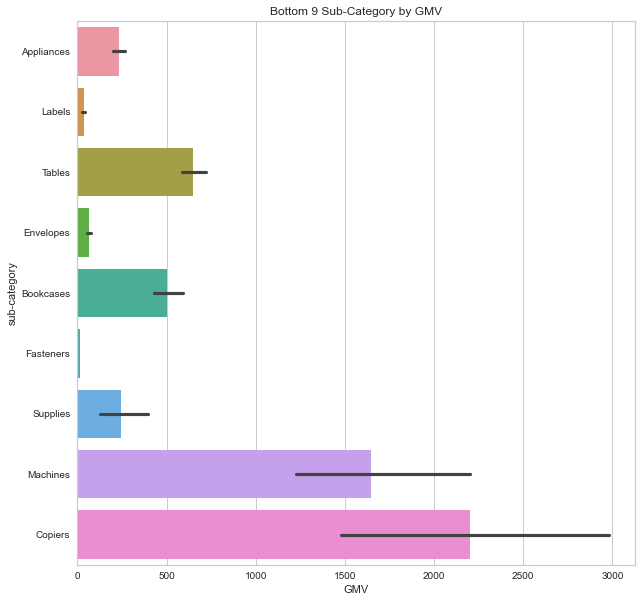

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Bottom 9 Sub-Category by GMV")
ax = sns.barplot(data = df2, x='GMV', y='sub-category', order = df2['sub-category'].value_counts().tail(9).index)
plt.show()

Findings: 
1. Jika kita bandingkan antara GMV dan Profit, hal ini mengindikasikan bahwa Super Store melakukan promosi pada Sub-Kategori 9 Terbawah karena perbedaan antara GMV dan Profit sangat tinggi
2. Super Store melakukan promosi produk yang tepat namun perlu memaksimalkan promosi atau melakukan evaluasi produk

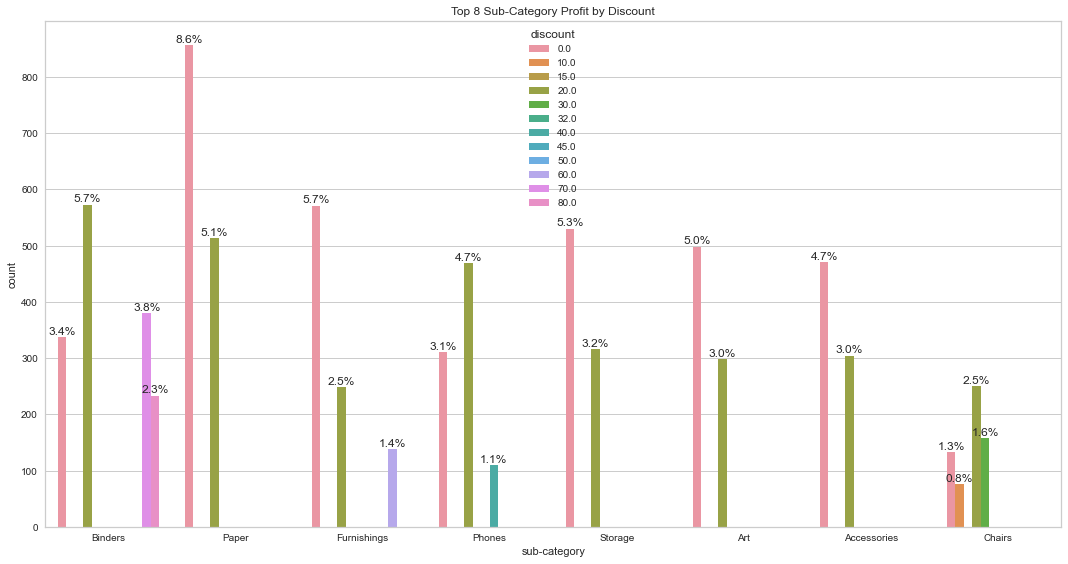

In [34]:
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.countplot(x='sub-category',hue='discount', order = df2['sub-category'].value_counts().head(8).index, data = df2)
plt.title("Top 8 Sub-Category Profit by Discount")
total1 = len(df2)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
1. Secara keseluruhan Promo diskon yang dilakukan cukup bagus untuk Top 8 Sub-Kategori, namun masih kuranag maksimal
2. Super Store perlu membuat promo yang efisien untuk mengefisienkan biaya promosi di Top 8 Sub-Kategori
3. Super Store dapat membuat program Loyalty karena untuk mengefisienkan promosi
4. Pelanggan biasanya membeli produk karena mereka membutuhkannya, karena presentase diskon 0,0% sangat tinggi
5. Sehingga Super Store dapat memaksimalkan profit dengan melakukan efisiensi biaya promosi pada Top 8 Sub-Kategori

In [139]:
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.countplot(x='sub-category',hue='discount', order = df2['sub-category'].value_counts().tail(9).index, data = df2)
plt.title("Bottom 9 Sub-Category Profit by Discount")
total1 = len(df2)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
1. Secara keseluruhan Promo diskon yang dilakukan cukup bagus untuk Sub-Kategori 9 Terbawah, namun masih belum maksimal karena GMVnya juga masih belum tinggi
2. Presentase diskon 0,0% sangat tinggi yang menandakan, pelanggan membeli produk tanpa promosi
3. Karena Super Store perlu memperkenalkan Sub-Kategori 9 Terbawah, mereka perlu membuat promosi atau acara yang bagus berdasarkan produk Sub-Kategori 9 Terbawah
4. Dari jumlah ordernya juga, masih belum terlalu tinggi, namun penggunaan promonya banyak

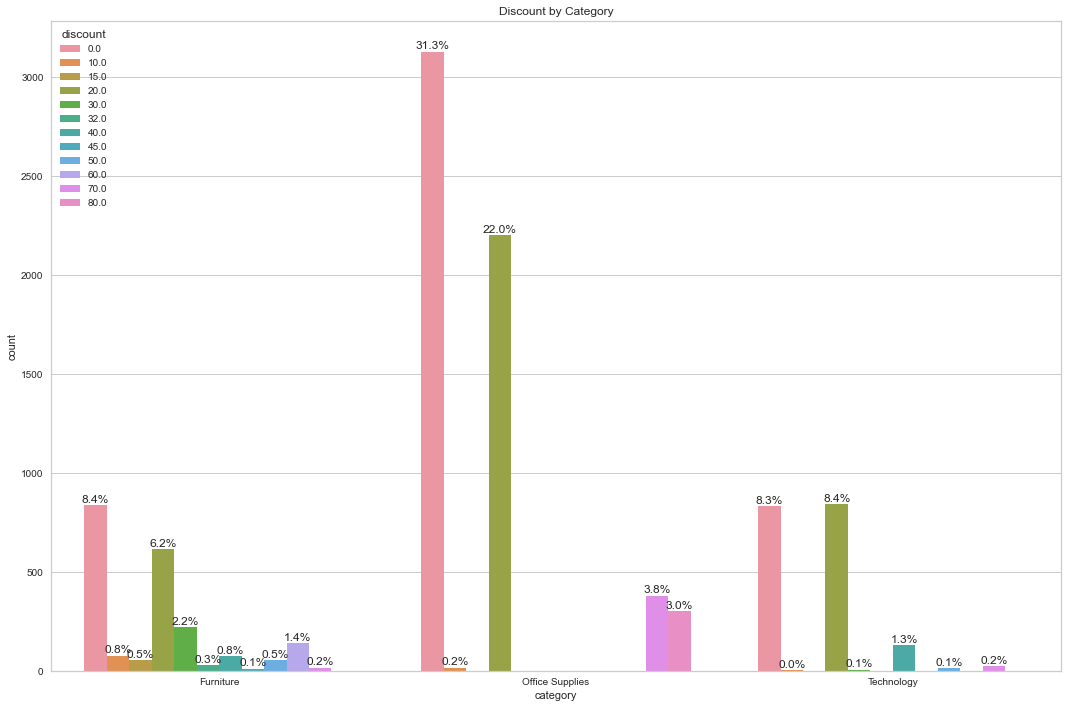

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.countplot(x='category',hue='discount', data = df2)
plt.title("Discount by Category")
total1 = len(df2)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
1. Penggunaan diskon pada kategori office supplies sangat tinggi 
2. Melakukan efisiensi cost pada category tersebut dapat meningkatkan profit 
3. Pembeli sudah terbiasa membeli produk tersebut, dimana produk pada categori tersebut juga masuk ke top 8 produk 
4. Melakukan efektifitas promo yang tepat, dapat meningkatkan profit Super Store

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.countplot(x='region',hue='discount', data = df2)
plt.title("Discount by Region")
total1 = len(df2)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
1. Promo yang dilakukan region South, West, dan East bisa dikurangi agar meningkatkan profit
2. Pada region tersebut, dapat diindikasikan bahwa banyak pelanggang yang loyal atau pelanggan lama
3. Prodit dan GMV dari ketiga region tersebut juga sudah cukup tinggi 
4. Perlu adanya peningkatan dari sisi layanan dan inovasi produk, agar pelanggan dapat tetap loyal pada region tersebut 
5. Supoer Store bisa fokus pada region central agar meningkatkan pelanggan baru dan membuat pelanggan terbiasa dan nyamana berbelanja 

In [38]:
unique = df2['discount'].unique()

In [39]:
unique.sort()

In [40]:
unique

array([ 0., 10., 15., 20., 30., 32., 40., 45., 50., 60., 70., 80.])

In [41]:
df3 = df2.copy()

In [42]:
df3['year'] = df3['order_date'].apply(
    lambda x: x.strftime('%Y'))

In [43]:
df3['discount'] = df3['discount'].replace([10., 15., 20., 30., 32., 40., 45., 50., 60., 70., 80.], 'discount_promotion')

In [44]:
group = df3.groupby(["discount", "year"])["profit"].aggregate(sum)

In [45]:
group1 = group.sum(level=0)
new_cols= list(zip(group1.index.get_level_values(0),['total'] * len(group.index)))
group1.index = pd.MultiIndex.from_tuples(new_cols)

In [46]:
group_concat = pd.concat([group,group1]).sort_index()
print(group_concat)

discount            year 
0.0                 2014      58617.1665
                    2015      68870.7566
                    2016      89341.9679
                    2017     104157.7122
                    total    320987.6032
discount_promotion  2014      -9073.1924
                    2015      -7252.1529
                    2016      -7546.7936
                    2017     -10718.4426
                    total    -34590.5815
Name: profit, dtype: float64


In [47]:
test = df2.groupby(["discount","segment"],as_index=False).agg(Total_Quantity=('quantity', 'sum'),
                                                              Total_Profit=('profit', 'sum'), 
                                                  Avg_Unite_Price=('unit_price', 'mean'))

In [48]:
fig =  ff.create_table(test)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

Findings : 
1. Dari tabel berikut, kita bisa lihat bahwa promo diskon yang diberikan dari mulai 30% - 80% menghasilkan nilai minus
2. Perlu adanya perubahan promo diskon yang tepat sasaran dan sesuai 
3. Adanya program loyalty dapat memberikan promo ke pelanggan yang sesuai 
4. Dari segi segment Corporate dan Home Office, lebih baik memberikan penawaran harga yang baik dibandingkan dengan memberikan promo diskon 
5. Perlu adanya kontrak atau pembuatan kesepatakan penjualan pada Corporate atau Home Office dengan penawaran harga yang baik agar dapat meningkatkan profit dan tidak begitu menghabiskan cost promotion 
6. Promosi diskon juga tetap diberikan kepada Corporate atau Home Office namun, sesuai dengan budget promosi yang ada yang mengacu pada peningkatan profit 
7. Pembuatan promosi-promosi yang bersifat periodik juga sangat bagus untuk mengefisiensikan biaya promosi 
8. Adanya profit yang 0 bisa divalidasi kembali, dikawatirkan adanya kesalahan pada data, atau memang produknya dilakukan promo giveaway
9. Harga produk juga dapat dijadikan acuan untuk menetukan diskon, agar promo yang diberikan tidak berlebih Ex : harga tinggi diskon rendah atau harga rendah diskon tinggi namun disesuaikan kembali dengan profit

In [49]:
test2 = df2.groupby(["discount","category","region"], as_index=False).agg(Total_Customer=('customer_id', 'count'), Total_Profit=('profit', 'sum'), 
                                                  avg_unite_price=('unit_price', 'mean'))

In [50]:
fig =  ff.create_table(test2)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

Fingsings :
1. Pemberian promo sudah cukup bagus, karena promo diberikan pada produk yang rata-rata harganya tinggi 
2. Pengguna yang tidak menggunakan promo diskon juga cukup banyak, namun memang hanya pada produk yang harganya standard atau murah 
3. Dari table tersebut, perlu adanya pengurangan nilai diskon pada region South, West, East pada nilai diskon diatas 20% karena memang, pengguna lebih banyak tidak memakai diskon dan promo diskon
4. Promo diskon pada regional Central juga perlu dievaluasi kembali karena region Central sudah mendapatkan customer yang banyak, dan promo dapat digunakan pada region South karena, jumlah customernya paling rendah, sehingga perlu adanya promo untuk pengguna baru pada region South

In [51]:
sns.scatterplot(data=df2, x="profit", y="quantity", hue = "discount")

<AxesSubplot:xlabel='profit', ylabel='quantity'>

Findings :
1. Dari plot berikut, terlihat bahwa tidak terdapat pengaruh yang signifikan dari promo diatas 30% terhadap profit dan quantity
2. Promo seharusnya dapat meningkatkan quantity pembelian, namun promo diskon yang rendah dan tidak menggunakan promo diskon cenderung memiliki quantity yang banyak
3. Oleh karena itu, perlu adanya evaluasi pada promo diskon yang diberikan

In [52]:
df2['year'] = df2['order_date'].apply(
    lambda x: x.strftime('%Y'))

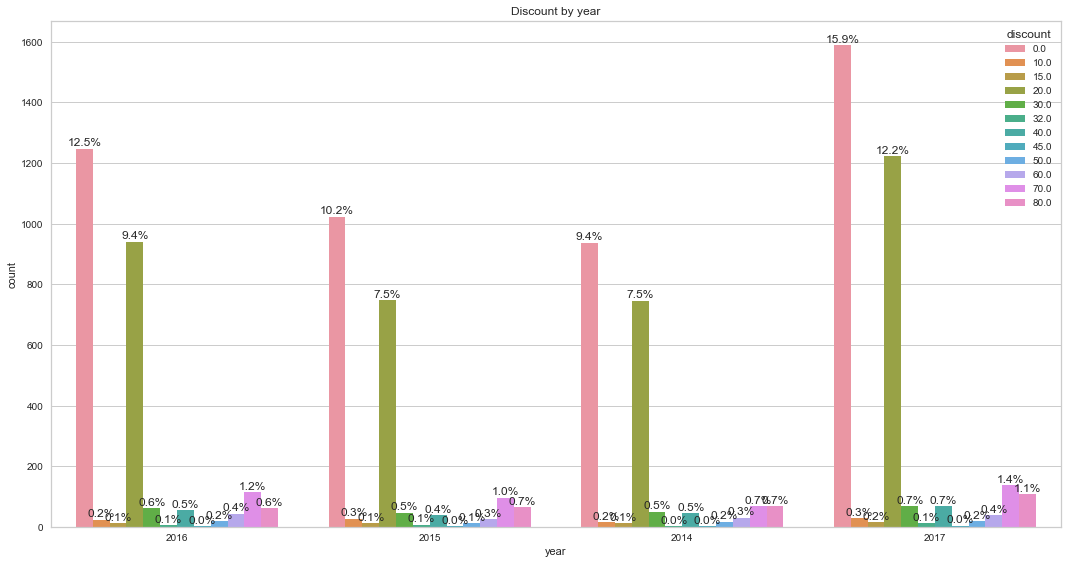

In [53]:
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.countplot(x='year',hue='discount', data = df2)
plt.title("Discount by year")
total1 = len(df2)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
1. Promo diskon diberikan dari tahun ketahun 
2. Terdapat penurunan dan naik kembali pada tahun 2017 
3. Dari tahun ke tahun, bisa dilihat dari plot, promo diskon yang memiliki tingkat efektifitas promo yaitu diskon 20% dan 70% - 80%
4. Pengguna yang tidak menggunakan promo diskon juga lebih tinggi disetiap tahunnya mengartikan bahwa, banyak pengguna yang memang membeli barang tanpa memerlukan promo diskon dan banyaknya pengguna loyal pada Super Store 
5. Oleh karena itu, untuk mengefisiensikan biaya promo diskon dan meningkatkan profit, evaluasi pemberian promo diskon dapat dilakukan, sebaagai contoh, dengan melakukan program loyalty 

## RFM

In [54]:
df2['order_date'].max()

Timestamp('2017-12-30 00:00:00')

In [55]:
analysis_date_1 = df2['order_date'].max()

In [56]:
data_1 = df2.groupby(['customer_id'], as_index=False).agg({
        'order_date': lambda x: (analysis_date_1 - x.max()).days,
        'order_id': 'count',
        'GMV': 'sum'})

In [57]:
data_1.rename(columns={'order_date': 'Recency',
                         'order_id': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

In [58]:
data_1 = data_1[data_1['GMV'] > 0]

In [59]:
data_1

customer_id  Recency  Frequency       GMV
0      AA-10315      184         11  5563.560
1      AA-10375       19         15  1056.390
2      AA-10480      259         12  1790.512
3      AA-10645       55         18  5086.935
4      AB-10015      415          6   886.156
..          ...      ...        ...       ...
788    XP-21865       43         28  2374.658
789    YC-21895        4          8  5454.350
790    YS-21880        9         12  6720.444
791    ZC-21910       54         31  8025.707
792    ZD-21925      202          9  1493.944

[793 rows x 4 columns]

In [60]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_groups = pd.qcut(data_1['Recency'], q=4, labels = r_labels)
f_groups = pd.qcut(data_1['Frequency'], q=4, labels = f_labels)
m_groups = pd.qcut(data_1['GMV'], q=4, labels = m_labels)

In [61]:
list(range(1, 5))

[1, 2, 3, 4]

In [62]:
list(range(4, 0, -1))

[4, 3, 2, 1]

In [63]:
data_1 = data_1.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

In [64]:
data_1['rfm_score'] = data_1[['R','F','M']].apply(
    lambda x: ''.join(x.astype(str)),
    axis=1
)

In [65]:
data_1['rfm_score'] = data_1['rfm_score'].astype('int')

In [66]:
data_1.head(5)

customer_id  Recency  Frequency       GMV  R  F  M  rfm_score
0    AA-10315      184         11  5563.560  1  2  4        124
1    AA-10375       19         15  1056.390  4  3  1        431
2    AA-10480      259         12  1790.512  1  2  2        122
3    AA-10645       55         18  5086.935  3  4  4        344
4    AB-10015      415          6   886.156  1  1  1        111

In [67]:
check_1 = data_1.loc[(data_1.Recency.max()) & (data_1.R == 1)]

In [68]:
check1 = check_1['Recency'].unique()

In [69]:
check1.sort()

In [70]:
check1

array([ 184,  186,  187,  188,  189,  192,  193,  196,  197,  198,  200,
        201,  202,  203,  204,  205,  210,  212,  215,  217,  218,  221,
        223,  224,  225,  226,  230,  232,  236,  238,  239,  240,  241,
        242,  244,  247,  249,  253,  254,  259,  264,  265,  273,  277,
        278,  282,  284,  285,  286,  287,  289,  295,  296,  299,  300,
        302,  307,  320,  327,  334,  336,  337,  338,  344,  345,  349,
        350,  352,  357,  358,  362,  365,  369,  376,  385,  386,  387,
        390,  391,  394,  399,  401,  404,  405,  406,  407,  409,  410,
        413,  414,  415,  421,  424,  432,  434,  436,  452,  457,  461,
        463,  464,  467,  470,  481,  483,  484,  489,  491,  496,  501,
        504,  519,  525,  534,  549,  552,  555,  558,  560,  581,  582,
        583,  593,  606,  614,  637,  648,  659,  688,  691,  700,  708,
        719,  737,  753,  758,  765,  769,  771,  776,  777,  781,  799,
        812,  835,  845,  882, 1000, 1035, 1097, 11

In [71]:
check_2 = data_1.loc[(data_1.Recency.max()) & (data_1.R == 4)]

In [72]:
check_2.head(5)

customer_id  Recency  Frequency       GMV  R  F  M  rfm_score
1     AA-10375       19         15  1056.390  4  3  1        431
8     AB-10165       25         14  1113.838  4  3  1        431
12    AC-10450       11          9  5527.846  4  2  4        424
13    AC-10615        6         18  2537.686  4  4  3        443
15    AD-10180       29         12  6106.880  4  2  4        424

In [73]:
check2 = check_2['Recency'].unique()

In [74]:
check2.sort()

In [75]:
check2

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64)

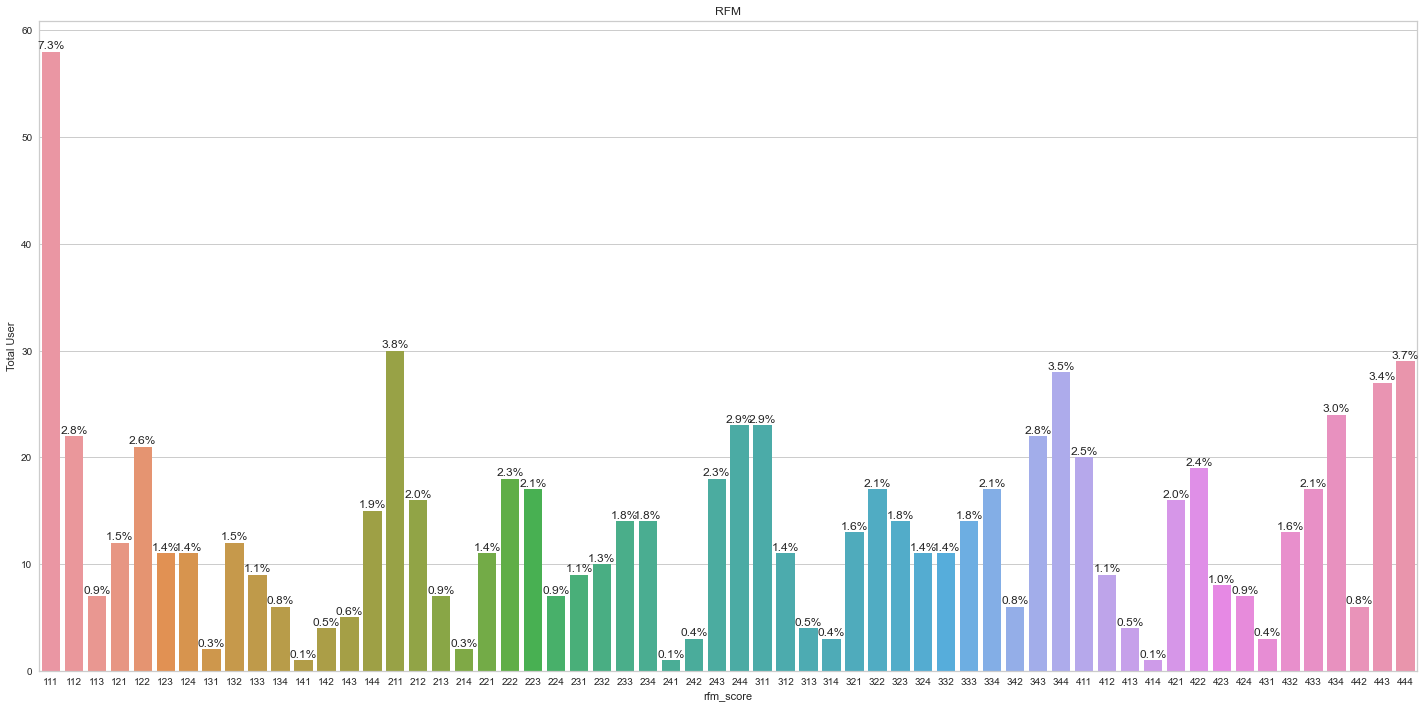

In [76]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x='rfm_score', data=data_1)
plt.ylabel('Total User')
plt.title('RFM')
total_check = len(data_1)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total_check:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
1. Presentase customer tertinggi yaitu pada 111 yang menandakan tingkat churn yang tinggi 
2. Presentase tertinggi kedua juga terdapat pada pelanggan yang butuh perhatian 
3. Dari RFM Segment berikut, menunjukan kondisi yang masih cukup normal, karena untuk segement Champion, Loyal Customer, dan Promising masih cukup banyak
4. Perlu adanya tindakan pencegahan agar pelanggan tidak churn dan terlihat juga banyak pelanggan yang masuk ke segment At Risk

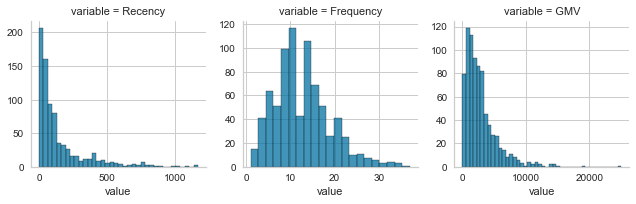

In [77]:
g = sns.FacetGrid(
    data = pd.melt(
    data_1[["Recency", "Frequency","GMV"]],
    value_vars=["Recency","Frequency", "GMV"]
    ),
    col = "variable",
    sharex = False,
    sharey = False
)
g.map(sns.histplot, "value");

Finding :
1. Berdasarkan dari distibusi data, telihat Scew ke kanan, namun untuk frequency cukup oke
2. Secara keseluruhan, untuk distribusi data masih terlihat normal 
3. Untuk nilai Recency juga cukup oke dimana, nilai Recencynya distibusinya rata-rata berada mendekati 0 

In [78]:
sns.scatterplot(data=data_1, x="Frequency", y="GMV")

<AxesSubplot:xlabel='Frequency', ylabel='GMV'>

Findings :
1. Berdasarkan hubungan antara GMV dan Frequency sudah cukup bagus
2. Namun, perlu dilakukan pemaksimalan peningkatan GMV karena, frequency pembelinya sudah tinggi 

In [79]:
sns.scatterplot(data=data_1, x="Recency", y="GMV")

<AxesSubplot:xlabel='Recency', ylabel='GMV'>

Findings :
1. Untuk hubungan antara Rencency dan GMV juga cukup bagus
2. Recencynya memiliki nilai kecil, dan GMV juga tinggi pada Recency yang mendekati 0 

In [80]:
cek = data_1["rfm_score"].unique()

In [81]:
cek.sort()

In [82]:
cek

array([111, 112, 113, 121, 122, 123, 124, 131, 132, 133, 134, 141, 142,
       143, 144, 211, 212, 213, 214, 221, 222, 223, 224, 231, 232, 233,
       234, 241, 242, 243, 244, 311, 312, 313, 314, 321, 322, 323, 324,
       332, 333, 334, 342, 343, 344, 411, 412, 413, 414, 421, 422, 423,
       424, 431, 432, 433, 434, 442, 443, 444])

In [83]:
data_1['rfm_segment'] = np.select(
    [
     data_1['rfm_score'].isin([444]),
     data_1['rfm_score'].isin([333, 334, 343, 344, 433, 434, 443]),
     data_1['rfm_score'].isin([321, 322, 323, 324, 331, 332, 341, 342, 412, 413, 414, 421, 422, 423, 424, 431, 432, 441, 442]),
     data_1['rfm_score'].isin([411]),
     data_1['rfm_score'].isin([221, 222, 223, 224, 231, 232, 241, 242, 311, 312, 313, 314]),
     data_1['rfm_score'].isin([133, 134, 143, 144, 233, 234, 243, 244]),
     data_1['rfm_score'].isin([112, 113, 114, 121, 122, 123, 124, 131, 132, 141, 142, 211, 212, 213, 214]),
     data_1['rfm_score'].isin([111])
    ],
    [
     'Champion',
     'Loyal Customers',
     'Promising',
     'Recent Customers',
     'Customer Needing Attention',
     "Can't Lose Them",
     "At Risk",
     "Lost"
    ]
)

In [84]:
data_1.head()

customer_id  Recency  Frequency       GMV  R  F  M  rfm_score  \
0    AA-10315      184         11  5563.560  1  2  4        124   
1    AA-10375       19         15  1056.390  4  3  1        431   
2    AA-10480      259         12  1790.512  1  2  2        122   
3    AA-10645       55         18  5086.935  3  4  4        344   
4    AB-10015      415          6   886.156  1  1  1        111   

       rfm_segment  
0          At Risk  
1        Promising  
2          At Risk  
3  Loyal Customers  
4             Lost

In [85]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 0 to 792
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   customer_id  793 non-null    object  
 1   Recency      793 non-null    int64   
 2   Frequency    793 non-null    int64   
 3   GMV          793 non-null    float64 
 4   R            793 non-null    category
 5   F            793 non-null    category
 6   M            793 non-null    category
 7   rfm_score    793 non-null    int32   
 8   rfm_segment  793 non-null    object  
dtypes: category(3), float64(1), int32(1), int64(2), object(2)
memory usage: 43.0+ KB


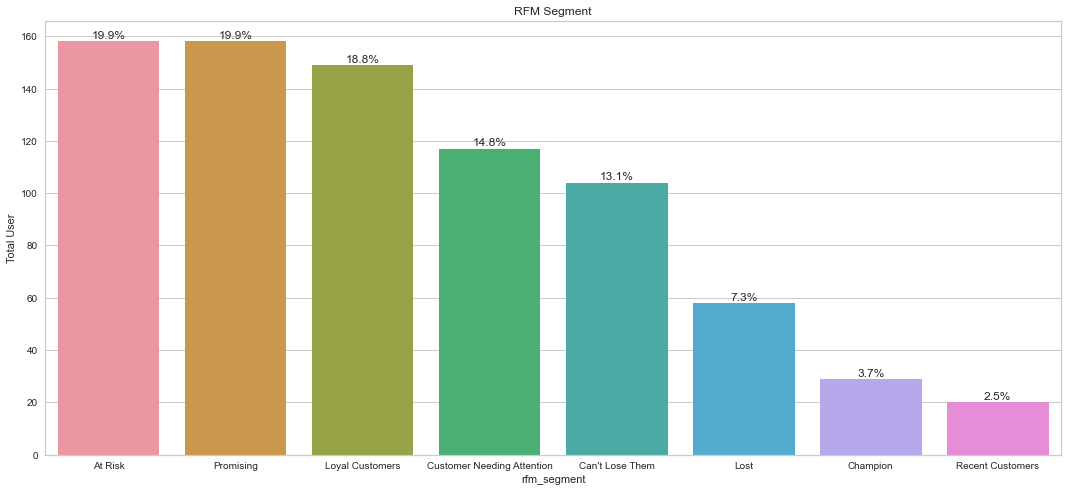

In [86]:
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.countplot(x='rfm_segment', data=data_1, order = data_1['rfm_segment'].value_counts().index)
plt.ylabel('Total User')
plt.title('RFM Segment')
total_check = len(data_1)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total_check:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
1. Berdasarkan dari barplot berikut, untuk segment pelanggan Super Store sangat baik 
2. Untuk nilai Lost juga rendah 
3. Banyaknya pelanggan yang loyal dan Promissing dapat dijadikan target dalam meningkatkan Profit
4. Perlu adanya interfensi pada segment At Risk agar pelanggan tetap setia dan nyaman bertransaksi pada Super Store agar tidak churn
5. Dari barplot berikut, perlu adanya program Loyalty agar dapat mengefisiensikan biaya promo dengan melakukan target customers berdasarkan loyalty level
6. RFM Segment juga dapat dijadikan acuan untuk membuat program Loyalty

## Clustering

In [87]:
data_model = data_1[["Recency", "Frequency", "GMV"]]

### Checking Correlation 

<AxesSubplot:>

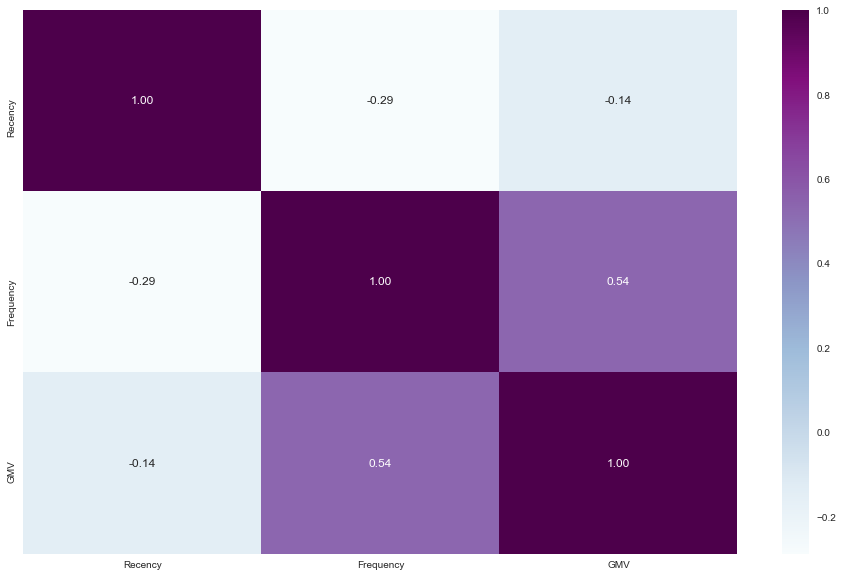

In [88]:
corr_= data_model.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

Findings :
1. Tidak terdapat nilai korelasi yang tinggi tiap variable
2. Nilai korelasi yang tinggi yaitu 0.54 yaitu GMV dan Frequency dan masih oke

### Data Prepossessing

In [89]:
scaler_obj = StandardScaler()
scaled_data = scaler_obj.fit_transform(data_model[["Recency", "Frequency", "GMV"]].to_numpy())
data_for_kmeans = pd.DataFrame(scaled_data, columns = ["Recency", "Frequency", "GMV"])

### PCA

In [90]:
pca = PCA(2)
data_model_1 = pca.fit_transform(data_for_kmeans)

In [91]:
pca.n_components_

2

In [92]:
pcaSummary = pd.DataFrame({'std_deviation': np.sqrt(pca.explained_variance_),
              'prop_of_variance' : pca.explained_variance_ratio_,
              'cum_prop_var': np.cumsum(pca.explained_variance_ratio_)})
pcaSummary_tps = pcaSummary.transpose()
pcaSummary_tps.columns = ['PC{}'.format(i) for i in range(1,len(pcaSummary_tps.columns) + 1)]
pcaSummary_tps

PC1       PC2
std_deviation     1.295016  0.940381
prop_of_variance  0.558317  0.294401
cum_prop_var      0.558317  0.852718

Findings :
1. Dari informasi yang diberikan dari PCA sudah mencapai 80 % 
2. Oleh karena itu digunakan 2 PCA

### K-Means Cluster 

In [93]:
kmeans_model = KMeans(
    n_clusters = 4,
    random_state=1000
)

kmeans_model.fit(data_model_1)

KMeans(n_clusters=4, random_state=1000)

In [94]:
np.unique(kmeans_model.labels_, return_counts = True)

(array([0, 1, 2, 3]), array([288, 102, 329,  74], dtype=int64))

In [95]:
data_1["cluster"] = kmeans_model.labels_

In [96]:
data_1

customer_id  Recency  Frequency       GMV  R  F  M  rfm_score  \
0      AA-10315      184         11  5563.560  1  2  4        124   
1      AA-10375       19         15  1056.390  4  3  1        431   
2      AA-10480      259         12  1790.512  1  2  2        122   
3      AA-10645       55         18  5086.935  3  4  4        344   
4      AB-10015      415          6   886.156  1  1  1        111   
..          ...      ...        ...       ... .. .. ..        ...   
788    XP-21865       43         28  2374.658  3  4  3        343   
789    YC-21895        4          8  5454.350  4  1  4        414   
790    YS-21880        9         12  6720.444  4  2  4        424   
791    ZC-21910       54         31  8025.707  3  4  4        344   
792    ZD-21925      202          9  1493.944  1  2  2        122   

         rfm_segment  cluster  
0            At Risk        0  
1          Promising        2  
2            At Risk        2  
3    Loyal Customers        0  
4               Lost        1  
..               ...      ...  
788  Loyal Customers        0  
789        Promising        0  
790        Promising        0  
791  Loyal Customers        3  
792          At Risk        2  

[793 rows x 10 columns]

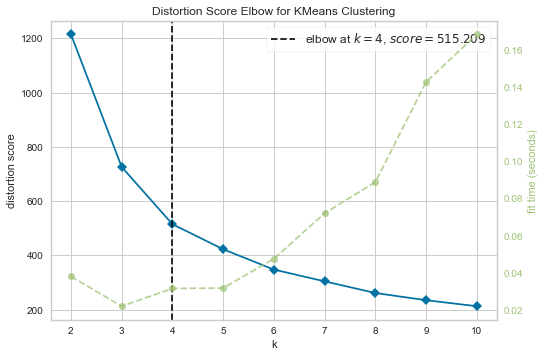

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [97]:
model = KElbowVisualizer(KMeans(random_state=1000), k=10)
model.fit(data_model_1)
model.show()

Findings :
1. Berdasarkan elbow methode nilai K terbaik adalah 4    

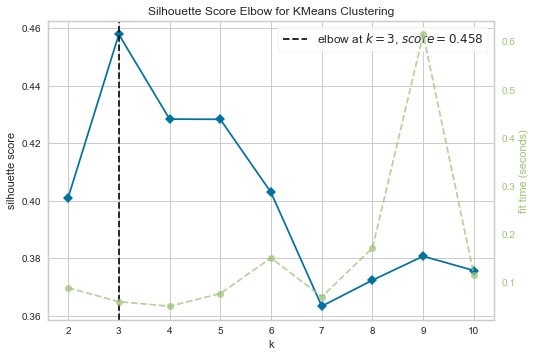

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [98]:
model = KElbowVisualizer(KMeans(random_state=1000), k=10, metric = "silhouette")
model.fit(data_model_1)
model.show()

Findings :
1. berdasarskan Silhouette Score Elbow nilai K terbaik adalah 3 

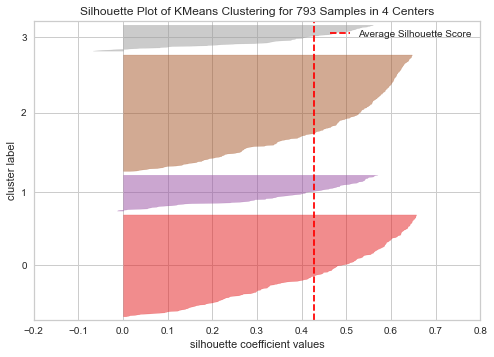

In [99]:
visualizer = SilhouetteVisualizer(kmeans_model, is_fitted = True)
visualizer.fit(data_model_1)
visualizer.show();

Findings :
1. Berdasarkan Silhouette Visualization jika dicek, untuk nolai error atau minus terendah ada pada nilai K = 4
2. Oleh karena itu, digunakan nilai K = 4

In [100]:
data_model_1 = pd.DataFrame(data_model_1, columns = ["PC1", "PC2"])
data_model_1['cluster'] = kmeans_model.labels_

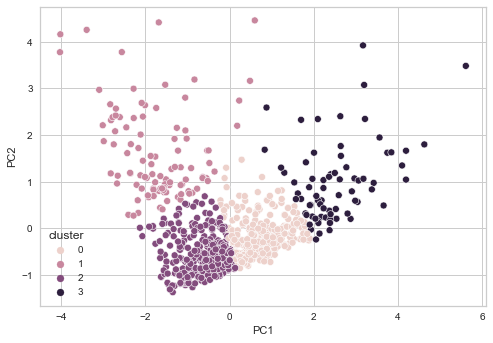

In [101]:
sns.scatterplot(data = data_model_1, x = "PC1", y = "PC2", hue = "cluster");

Findings :
1. Pengelompokan terlihat sangat baik dan terkelompok dengan sesuai untuk nilai K = 4

In [102]:
centroids = kmeans_model.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
colors = ['#DF2020', '#81DF20', '#2095DF', '#F50C20']
data_model_1['c'] = data_model_1.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3]})

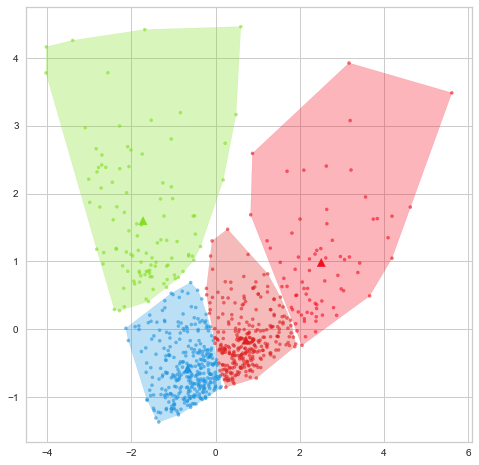

In [103]:
fig, ax = plt.subplots(1, figsize=(8,8))

plt.scatter(data_model_1.PC1, data_model_1.PC2, c=data_model_1.c, alpha = 0.6, s=10)
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

# draw enclosure
for i in data_model_1.cluster.unique():
    points = data_model_1[data_model_1.cluster == i][['PC1', 'PC2']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])

In [104]:
def myplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [105]:
pca_model = PCA()
pca_model.fit(data_for_kmeans)
pca_result = pca_model.transform(data_for_kmeans)

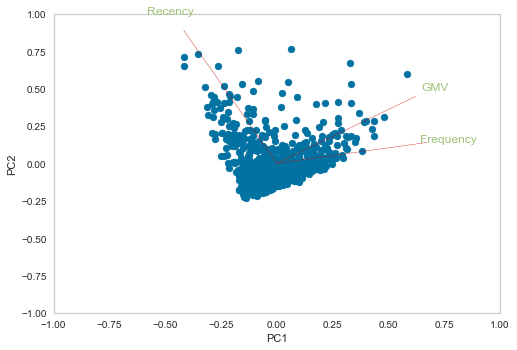

In [106]:
myplot(pca_result[:,0:3], np.transpose(pca_model.components_[0:3, :]), labels = ["Recency", "Frequency", "GMV"])
plt.show()

Findings :
1. berdasarkan Biplot PC1 1 terbentuk berdasarkan GMV dan Frequency (Spending Behavior)
2. PC2 terbentuk berdasarkan Recency (Seberapa sering pelanggan bertransaksi "Recency")

## Evaluation

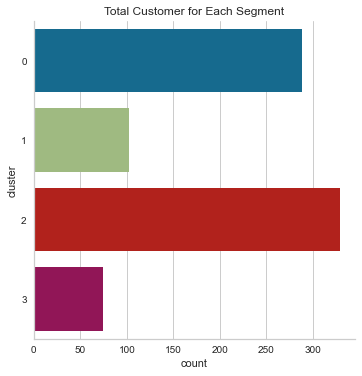

In [107]:
sns.catplot(
    y = "cluster", 
    data = data_1, 
    kind = "count", 
    height = 5
).ax.set_title("Total Customer for Each Segment");

Findings :
1. Cluster terbanyak terdapat pada Cluster 0 dan 2 
2. Cluster terendah adalah 3

<AxesSubplot:xlabel='cluster', ylabel='Recency'>

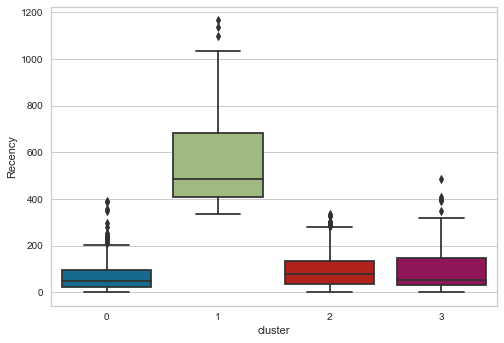

In [108]:
sns.boxplot(x = 'cluster', y = 'Recency', data = data_1)

Findings :
1. Berdasarkan boxplot, Cluster yang mendekati Churn yaitu Cluster 1
2. Cluster 0 adalah cluster yang paling sering bertransaksi

<AxesSubplot:xlabel='cluster', ylabel='Frequency'>

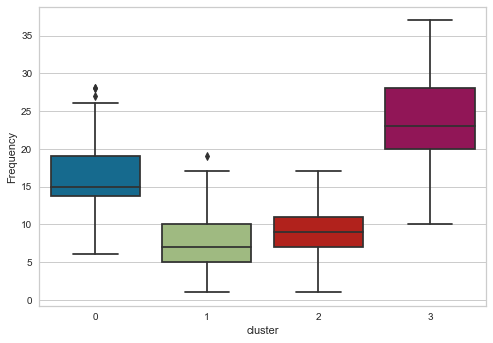

In [109]:
sns.boxplot(x = 'cluster', y = 'Frequency', data = data_1)

Findings :
1. Berdasarkan boxplot, untuk Cluster 3 dan 0 merupakan cluster unggulan dan cluster 1 adalah cluster yang kurang diungulkan dari sisi frequency 

<AxesSubplot:xlabel='cluster', ylabel='GMV'>

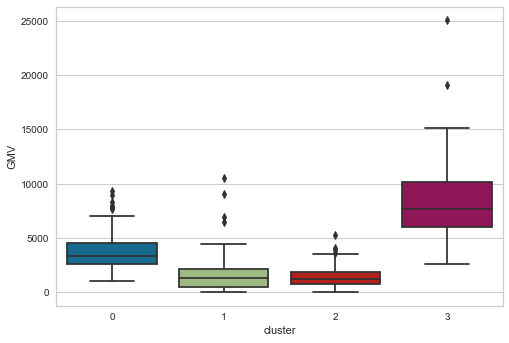

In [110]:
sns.boxplot(x = 'cluster', y = 'GMV', data = data_1)

Findings :
1. Berdasarkan boxplot GMV Cluster unggulan adalah Cluster 3
2. Dapat disimpulan dari hasil boxplot sebelumnya yaitu, cluster 3 adalah cluster platinum, cluster 0 adalah gold, silver adalah cluster 2 dan bronze adalah cluster 1 

In [111]:
data_1['rfm_score'] = data_1['rfm_score'].astype(object)

In [112]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 0 to 792
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   customer_id  793 non-null    object  
 1   Recency      793 non-null    int64   
 2   Frequency    793 non-null    int64   
 3   GMV          793 non-null    float64 
 4   R            793 non-null    category
 5   F            793 non-null    category
 6   M            793 non-null    category
 7   rfm_score    793 non-null    object  
 8   rfm_segment  793 non-null    object  
 9   cluster      793 non-null    int32   
dtypes: category(3), float64(1), int32(1), int64(2), object(3)
memory usage: 49.2+ KB


In [113]:
data_1.groupby("cluster")[['Recency','Frequency','GMV']].aggregate([min,max,sum,'mean','count'])

Recency                                Frequency                       \
            min   max    sum        mean count       min max   sum       mean   
cluster                                                                         
0             0   390  20027   69.538194   288         6  28  4624  16.055556   
1           336  1165  56155  550.539216   102         1  19   778   7.627451   
2             0   334  32176   97.799392   329         1  17  2870   8.723404   
3             2   484   8056  108.864865    74        10  37  1722  23.270270   

                    GMV                                              
        count       min        max           sum         mean count  
cluster                                                              
0         288  1050.636   9351.212  1.054011e+06  3659.759702   288  
1         102     4.833  10501.653  1.690439e+05  1657.292654   102  
2         329    16.739   5253.876  4.550858e+05  1383.239658   329  
3          74  2580.704  25043.050  6.190604e+05  8365.680646    74

1. Cluster 0 = Loyal (gold)
2. Cluster 1 = Churn (bronze)
3. Cluster 2 = Need Attention (silver)
4. Cluster 3 = Champion (Platinum)

In [114]:
df_new = df2.merge(data_1, on = 'customer_id')

In [115]:
df_new.head()

customer_id        order_id order_date   ship_date     ship_mode  \
0    CG-12520  CA-2016-152156 2016-11-08  11/11/2016  Second Class   
1    CG-12520  CA-2016-152156 2016-11-08  11/11/2016  Second Class   
2    CG-12520  CA-2017-164098 2017-01-26   1/27/2017   First Class   
3    CG-12520  US-2015-123918 2015-10-15  10/15/2015      Same Day   
4    CG-12520  US-2015-123918 2015-10-15  10/15/2015      Same Day   

  customer_name   segment        country       city     state  ...  year  \
0   Claire Gute  Consumer  United States  Henderson  Kentucky  ...  2016   
1   Claire Gute  Consumer  United States  Henderson  Kentucky  ...  2016   
2   Claire Gute  Consumer  United States    Houston     Texas  ...  2017   
3   Claire Gute  Consumer  United States     Dallas     Texas  ...  2015   
4   Claire Gute  Consumer  United States     Dallas     Texas  ...  2015   

  Recency Frequency    GMV_y  R  F  M  rfm_score  rfm_segment  cluster  
0     338         5  1148.78  1  1  2        112      At Risk        1  
1     338         5  1148.78  1  1  2        112      At Risk        1  
2     338         5  1148.78  1  1  2        112      At Risk        1  
3     338         5  1148.78  1  1  2        112      At Risk        1  
4     338         5  1148.78  1  1  2        112      At Risk        1  

[5 rows x 31 columns]

In [116]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9994 entries, 0 to 9993
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    9994 non-null   object        
 1   order_id       9994 non-null   object        
 2   order_date     9994 non-null   datetime64[ns]
 3   ship_date      9994 non-null   object        
 4   ship_mode      9994 non-null   object        
 5   customer_name  9994 non-null   object        
 6   segment        9994 non-null   object        
 7   country        9994 non-null   object        
 8   city           9994 non-null   object        
 9   state          9994 non-null   object        
 10  postal_code    9994 non-null   int64         
 11  region         9994 non-null   object        
 12  product_id     9994 non-null   object        
 13  category       9994 non-null   object        
 14  sub-category   9994 non-null   object        
 15  product_name   9994 n

In [117]:
df_new.rename(columns={'GMV_x': 'GMV'}, inplace=True)

In [118]:
df_new.groupby(["cluster","rfm_segment"])[['Recency','Frequency','GMV']].aggregate([min,max,sum,'mean','count'])

Recency                                  \
                                       min   max     sum        mean count   
cluster rfm_segment                                                          
0       At Risk                         90   385   35697  256.812950   139   
        Can't Lose Them                 76   390  156540  143.878676  1088   
        Champion                         1    30    4684   18.015385   260   
        Customer Needing Attention      56   180   28081  108.420849   259   
        Loyal Customers                  0    75   70911   33.120504  2141   
        Promising                        4    65   23158   31.421981   737   
1       At Risk                        336  1135  249092  500.184739   498   
        Can't Lose Them                391  1035   67433  725.086022    93   
        Lost                           352  1165  104405  558.315508   187   
2       At Risk                         76   334  132290  185.020979   715   
        Can't Lose Them                210   210    2730  210.000000    13   
        Customer Needing Attention      32   183   87275   97.405134   896   
        Lost                           189   300   26054  248.133333   105   
        Promising                        0    70   30552   29.575992  1033   
        Recent Customers                 0    30    1914   17.722222   108   
3       At Risk                        399   399    4788  399.000000    12   
        Can't Lose Them                 79   484  146150  194.866667   750   
        Champion                         2    28    6284   15.670823   401   
        Loyal Customers                  6    64   22415   42.533207   527   
        Promising                       43    69    1636   51.125000    32   

                                   Frequency                              \
                                         min max    sum       mean count   
cluster rfm_segment                                                        
0       At Risk                            8  22   2125  15.287770   139   
        Can't Lose Them                   13  26  18936  17.404412  1088   
        Champion                          18  23   5240  20.153846   260   
        Customer Needing Attention         6  21   3621  13.980695   259   
        Loyal Customers                   13  28  37559  17.542737  2141   
        Promising                          8  24  10991  14.913161   737   
1       At Risk                            2  17   4992  10.024096   498   
        Can't Lose Them                   13  19   1467  15.774194    93   
        Lost                               1   8   1107   5.919786   187   
2       At Risk                            2  17   6489   9.075524   715   
        Can't Lose Them                   13  13    169  13.000000    13   
        Customer Needing Attention         1  16   9300  10.379464   896   
        Lost                               2   8    649   6.180952   105   
        Promising                          5  15  10809  10.463698  1033   
        Recent Customers                   3   8    628   5.814815   108   
3       At Risk                           12  12    144  12.000000    12   
        Can't Lose Them                   14  34  18470  24.626667   750   
        Champion                          19  37  10447  26.052369   401   
        Loyal Customers                   15  34  13331  25.296015   527   
        Promising                         10  11    342  10.687500    32   

                                      GMV                          \
                                      min        max          sum   
cluster rfm_segment                                                 
0       At Risk                     2.286   3930.072   36913.0720   
        Can't Lose Them             1.240   4548.810  245655.2322   
        Champion                    1.788   1983.968   65711.6640   
        Customer Needing Attention  1.680   7999.980   71000.5166   
        

1. Cluster 0 = Loyal
2. Cluster 1 = Churn 
3. Cluster 2 = Need Attention
4. Cluster 3 = Champion

In [119]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [120]:
# df_new.groupby(["discount","cluster"])[['Recency','Frequency','GMV','quantity']].aggregate(
#     [min,max,sum,'mean','count'])

test2 = df_new.groupby(["discount","cluster"], as_index=False).agg(Total_Customer=('customer_id', 'count'),Mean_Recency=('Recency', 'mean'), Mean_Frequency=('Frequency', 'mean'),
                                                Total_GMV=('GMV', 'sum'), Total_Quantity =('quantity', 'sum'))

In [121]:
fig =  ff.create_table(test2)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

Findings :
1. Semua segement dari RFM dan K-Means, medapatkan promo diskon yang sama 
2. Oleh karena itu, perlu melakukan promo diskon yang lebih efisien agar profit bisa meningkat 
3. Dengan melakukan segmentasi, dapat memberikan promo dengan memilih segment mana yang dapat diberikan promosi 
4. Promo bisa diberikan dalamn bentuk voucher yang dikirimkan ke pelanggan sebelum berbelanja, agar dapat menarik pelanggan berbelanja
5. Memberikan harga coret pada display produk, dapat disesuaikan juga dengan nominal diskon produk yang akan diberikan berdasarkan segment pelanggan
6. Sehingga, bisa menentukan harga diskon produk awal terlebih dahulu, setelahnya saat pelanggan ingin melakukan pembayaran, terdapat diskon lagi yang dipotong dari diskon awal tersebut 
7. Pemberian promo diskon besar bisa dilakukan secara periodik dengan mengadakan event-event yang menarik pelanggan

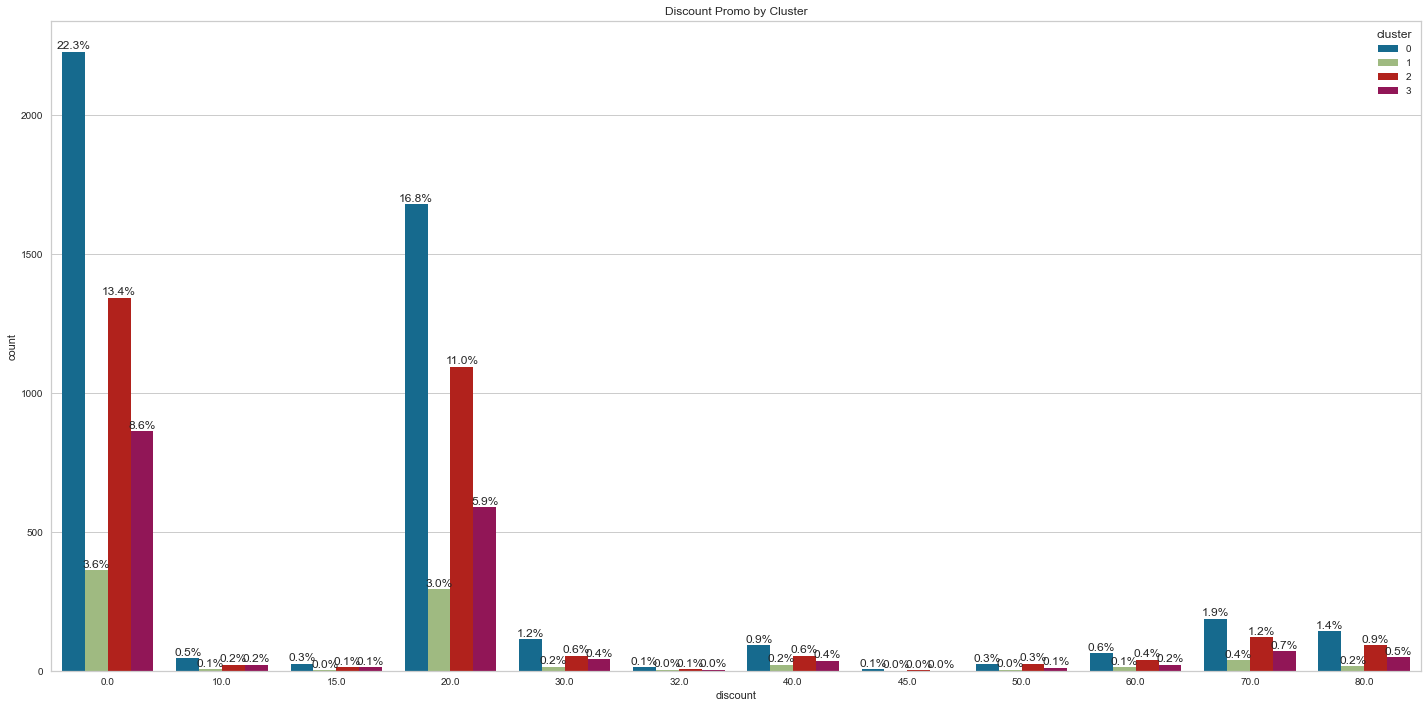

In [122]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(x='discount',hue='cluster', data = df_new)
plt.title("Discount Promo by Cluster")
total1 = len(df_new)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings:
1. Berdasarkan plot berikut, penggunaan promo diskon 20% sangat tinggi dan pengguna yang tidak menggunakan promo diskon juga sangat tinggi
2. Hal ini dapat menunjukan bahwa, pembeli melakukan transaksi tidak menggunakan diskon dikarenakan, memang senang berbelanja di super store dan membutuhkan produknya, bukan karena promo yang tinggi
3. Untuk Diskon yang tinggi dan diminati pelanggan yaitu 20%

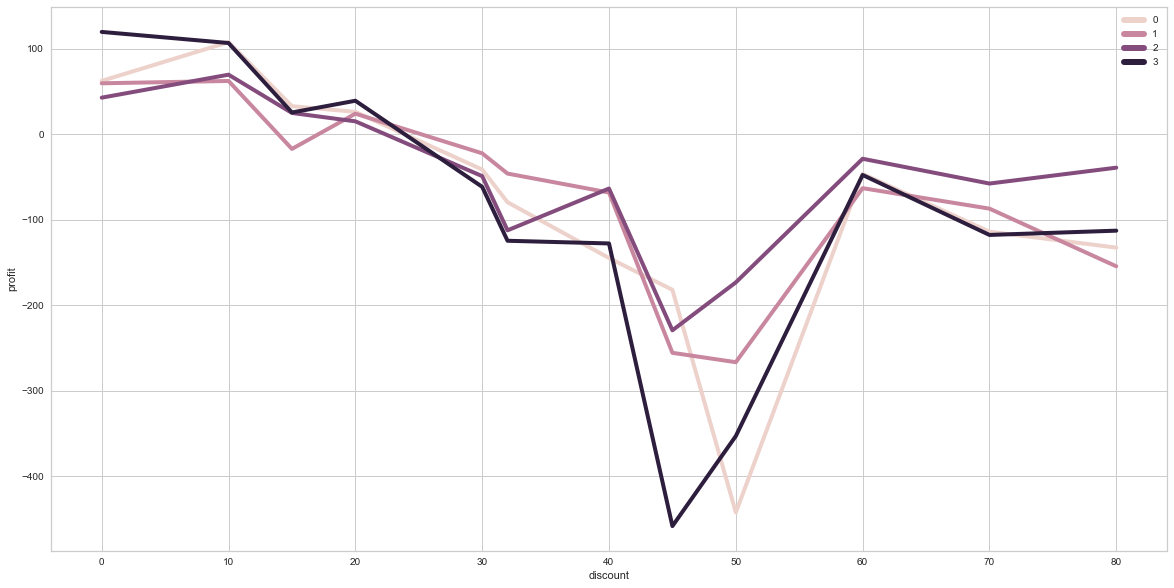

In [123]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(data=df_new, x="discount", y="profit", hue="cluster",ci=None, linewidth=4)
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.show()

Findings :
1. Berdasarkan line plot berikut, diskon yang memberikan keuntungan yaitu pada pada diskon maksimal 20% 
2. Sedangkan diskon 40-50% memberikan kerugian yang sangat tinggi 
3. Kerugian yang tinggi juga disebabkan oleh cluster 0 dan 3 yang merupakan cluster unggulan 
4. Seharusnya, promo tersebut dapat digunakan pada cluster 1 dan 2 agar dapat naik kelas ke cluster 0 atau 3 
5. Penggunaan promo masih belum efisien sehingga, profit dihasilkan masih belum maksimal

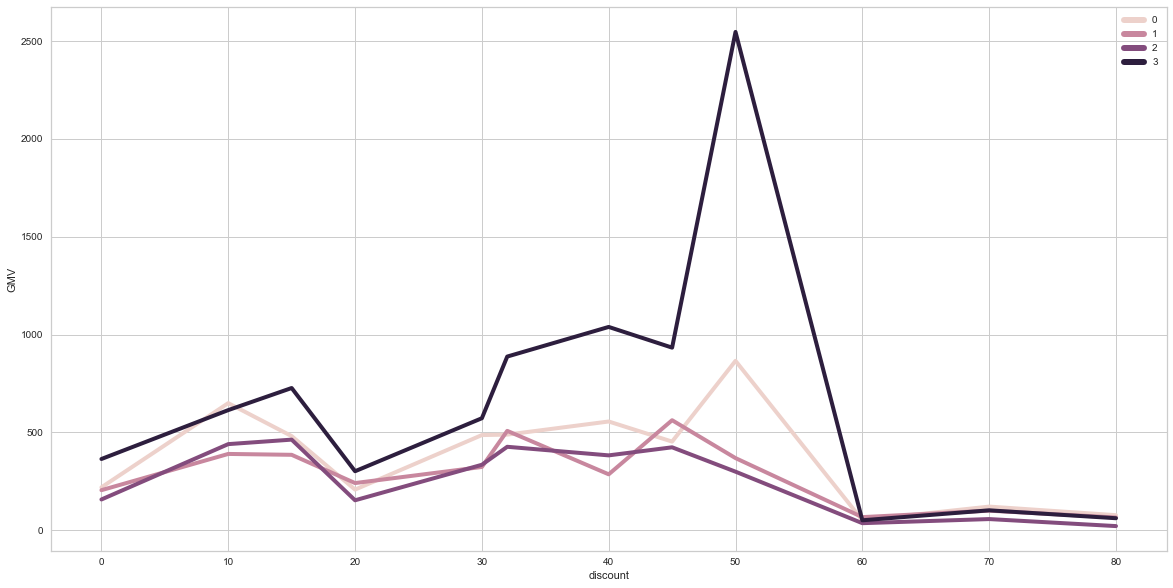

In [124]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(data=df_new, x="discount", y="GMV", hue="cluster",ci=None, linewidth=4)
leg = ax.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.show()

Findings:
1. Pemberian diskon memang memberikan peningkatan pada GMV
2. Pemberian diskon 50 meningkatkan GMV yang sangat tinggi, bisa diasumsikan, bahwa produk yang dibeli merupakan dari kategori teknologi karena harganya yang tinggi
3. Pemberian diskon 20 tidak memberikan kenaikan GMV yang maksimal, namun masih memberikan profit 

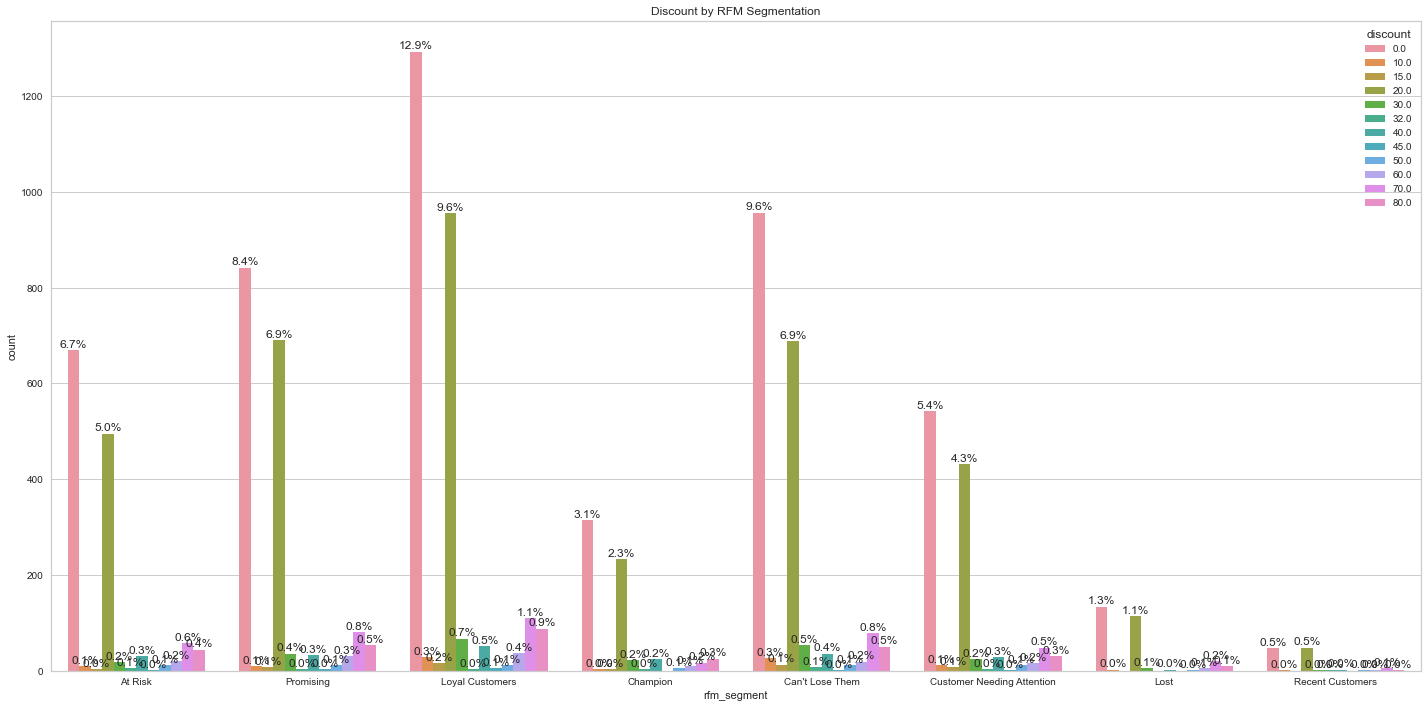

In [125]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(x='rfm_segment',hue='discount', data = df_new)
plt.title("Discount by RFM Segmentation")
total1 = len(df_new)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
1. Berdasarkan RFM Segmentation, pengguna yang menggunakan diskon 20% paling tinggi dan yang tidak menggunakan diskon juga tinggi 
2. Bisa diasumsikan bahwa penggunaan promo selain 20% tidak diberikan secara sering, namun nominalnya jika digabungkan tetap besar, sehingga terdapat minus pada profit yang tinggi jika pelanggan menggunakan diskon 
3. Perlu adanya pengaturan pemberian diskon ulang sesuai dengan segment atau membuat program loyalty berdasarkan segment, agar dapat mengefisienkan profit

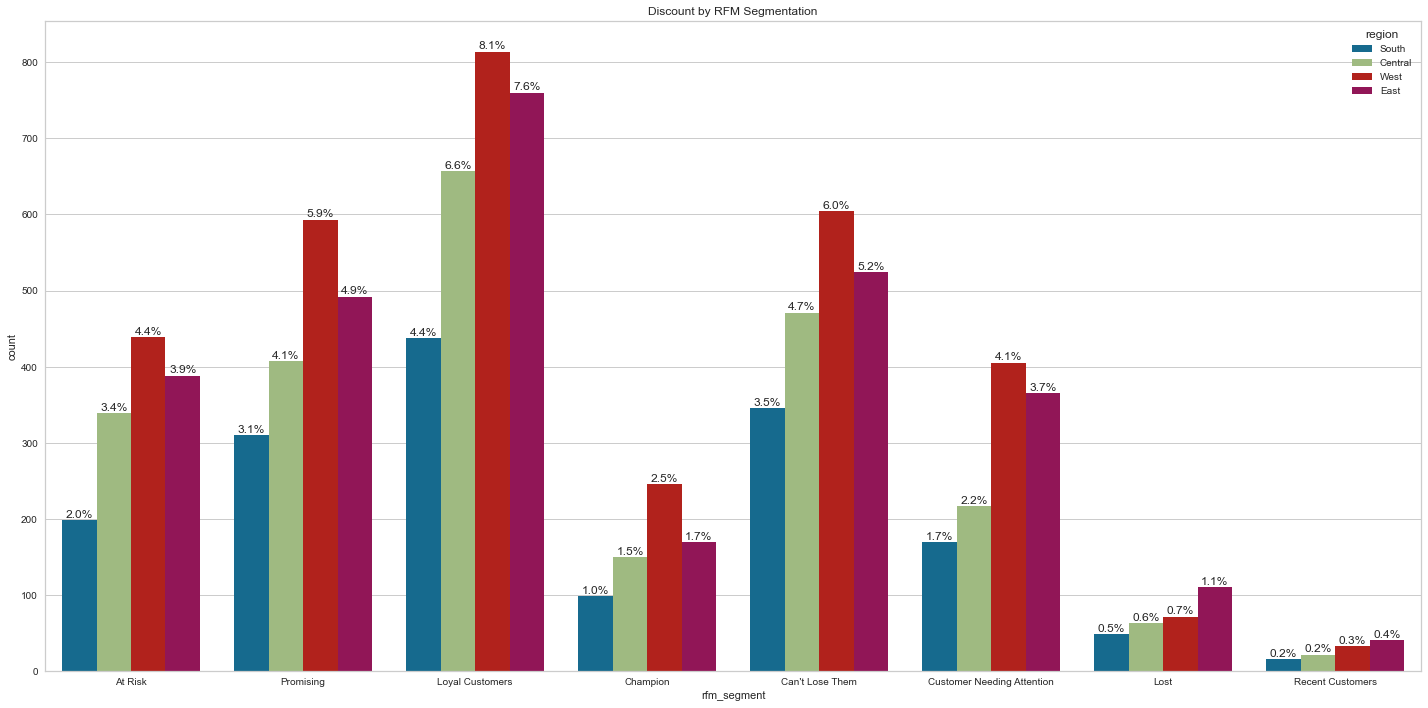

In [126]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(x='rfm_segment',hue='region', data = df_new)
plt.title("Discount by RFM Segmentation")
total1 = len(df_new)
for p in ax.patches:
      percentage = f'{100 * p.get_height() / total1:.1f}%\n'
      x = p.get_x() + p.get_width() / 2
      y = p.get_height()
      ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Findings :
1. Berdasarkan plot berikut, terlihat bahwa regional central bukan melakukan promo untuk meningkatkan pelanggan baru 
2. Nilai tertinggi pada Loyal Customers dan terendah pada recent customers
3. Tidak terlihat adanya pertumbuhan signifikat pada recent customers

In [127]:
central =  df_new.query('region == "Central"')

In [128]:
central = central.groupby(["discount","rfm_segment", "region"], as_index=False).agg(Total_Customer=('customer_id', 'count'),
                                                Total_profit=('profit', 'sum'))

In [129]:
fig =  ff.create_table(central)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)

Findings :
1. Berdasarkan tabel berikut, terlihat jelas memang recent customers menggunakan promosi paling sedikit
2. Untuk yang mendominasi penggunaan promo yaitu, loyal customers dan can't lose them 
3. Region Central melakukan promo untuk mempertahankan customers yang ada

<AxesSubplot:xlabel='discount', ylabel='Frequency'>

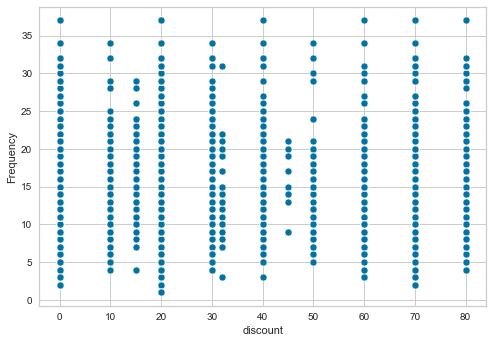

In [130]:
sns.scatterplot(data=df_new, x="discount", y="Frequency")

Findings :
1. Pemberian diskon tidak memberikan peningkatan signifikan pada frequency pelanggan bertransaksi
2. Sehingga, pelanggan bertransaksi bukan karena promo diskon, melainkan karena butuh produknya dan merasa nyaman bertransaksi

In [131]:
print('Total GMV =', df_new["GMV"].sum())
print('Total Profit =', df_new["profit"].sum())

Total GMV = 2297200.8603
Total Profit = 286397.0217


In [132]:
print('Different GMV and Profit =', df_new["GMV"].sum() - df_new["profit"].sum())

Different GMV and Profit = 2010803.8386


In [133]:
df_check = df_new.query('discount == 0')

In [134]:
print('Total GMV =', df_check["GMV"].sum())
print('Total Profit =', df_check["profit"].sum())

Total GMV = 1087908.47
Total Profit = 320987.6032


In [135]:
print('Different GMV and Profit =', df_check["GMV"].sum() - df_check["profit"].sum())

Different GMV and Profit = 766920.8668


In [136]:
df_check1 = df_new.query('discount > 0')

In [137]:
print('Total GMV =', df_check1["GMV"].sum())
print('Total Profit =', df_check1["profit"].sum())

Total GMV = 1209292.3903
Total Profit = -34590.5815


In [138]:
print('Different GMV and Profit =', df_check1["GMV"].sum() - df_check1["profit"].sum())

Different GMV and Profit = 1243882.9718000002


## Conclusion

1. Pemberian promo diskon dari Super Store sudah cukup baik berkisar 10 - 20% dari profit yang diterima, namun bisa lebih diefisienkan kembali dari sisi pemberian promo yang tepat dan sesuai dengan target pelanggan sehingga, dapat meningkatkan profit
2. Perbedaan nilai GMV dan Profit mencapai 2010803.8386 merupakan nilai yang sangat tinggi, sehingga memang perlu adanya evaluasi dari promo yang diberikan serta biaya operasional yang dikeluarkan
3. Program Loyalty diperlukan agar dapat memberikan promo sesuai dengan target pelanggan dan memberikan profit yang maksimal
4. Berdasarakan analisi yang dilakukan, region central merupakan region yang menjadi kelemahan dari Super Store dari sisi profit karena promo yang diberikan cukup tinggi, namun GMV yang dihasilkan sudah tinggi juga
5. Promo yang dapat diberikan yang baik untuk profit adalah 10-20% namun, sesuaikan dengan harga produknya serta profit yang dihasilkan
6. Perlu adanya peningkatan promo pada produk bottom agar dapat memperkenalkan produk dan meningkatkan order pada produk tersebut, agar kedepannya dapat meningkatkan profit

## Recommendation

1. Perlu dilakukan pembuatan Loyalty program berdasarkan segmentasi pelanggan dan juga dapat dilakukan juga dengan Customer Lifetime Value agar pemberian promosi sesuai dengan target pelanggan dan bisa meningkatkan profit
2. Melakukan evaluasi kembali pada promo diskon yang diberikan berdasarkan harga produk sehingga, profit bisa lebih maksimal dan pelanggan merasa mendapatkan harga pembelian yang terbaik Ex : harga tinggi diskon rendah atau harga rendah diskon tinggi namun sesuaikan kembaki dengan profitnya sehingga, nilai minusnya tidak bergitu tinggi
3. Penggunaan harga coret namun menyesuaikan dengan promo diskon yang diberikan ke pelanggan Ex : nilai produk yang tampil sudah dipotong 5% dan nantinya ketika bayar, pembeli dapat lagi diskon 5% jadi totalnya 10%
4. Pada program loyaly, dapat memberikan promo diskon melalui email atau pesan ke pelanggan menggunakan voucher, agar nantinya juga dapat mengundung pelanggan untuk datang dan bertransaksi
5. Perlu juga dilakukan evaluasi pada biaya operasional, agar lebih mengetahui kembali profit yang rendah disebabkan oleh diskon produk atau memang biaya operasional yang masih belum efektif dan efisien karena memang, selisih dari nilai GMV dan Profit sangat tinggi
6. Melakukan evaluasi biaya promosi dan operasional pada regional central agar dapat meningkatkan profit karena memang sudah 4 tahun berjalan namun, profit yang dihasilkan kurang maksimal
7. Pengalihan dana promosi ke promosi lainnya yang dapat memperkenalkan produk-produk bottom 9 dan meningkatkan penjualan pada produk tersebut, atau dapat melakukan evaluasi pada produk tersebut, apakah baiknya ditiadakan atau tetap diadakan produknya
8. Super Store dapat memilih K-Means Cluster atau RFM Segementation dalam pembagian kelompok pelanggan, karena hasil dari K-Means Cluster dan RFM Segmentation mirip, namun untuk RFM Segementation memiliki kelompok yang lebih detail dikarenakan terdapat banyak kelompok yang dihasilkan dari RFM Segementation